## <p style="text-align: center;">HyperParameter Tuning</p>

<p style="text-align: center;">In this Jupyter notebook, we will be optimizing a simple three layered Feed-Forward Neural Network and perform hyperparameter tuning in order to obtain a high-performing model. The simple MNISt-IRIS dataset will be used for this demonstration. We shall be tuning our Model based on Training Vs Validation Error plots </p>


In [1]:
import pandas as pd
import numpy as np
import scipy.special
import random
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
%matplotlib inline

In [2]:
Data = pd.read_csv('./IRIS.csv')

#Display five random entries
Data.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
38,4.4,3.0,1.3,0.2,Iris-setosa
66,5.6,3.0,4.5,1.5,Iris-versicolor
65,6.7,3.1,4.4,1.4,Iris-versicolor
98,5.1,2.5,3.0,1.1,Iris-versicolor
21,5.1,3.7,1.5,0.4,Iris-setosa


To make prediction easy we are going to assume:
- Iris-setosa as 0
- Iris-versicolor as 1
- Iris-virginica as 2

In [3]:
Data = Data.replace('Iris-setosa',0)
Data = Data.replace('Iris-versicolor',1)
Data = Data.replace('Iris-virginica',2)

#Shuffling the Data Set and keeping the Index the same
Data = Data.sample(frac=1).reset_index(drop=True)

#Display the 1st five entries
Data.iloc[0:6,:]  #iloc Fn is used to enable integer based indexing

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.0,2.0,3.5,1.0,1
1,6.5,3.0,5.5,1.8,2
2,6.8,2.8,4.8,1.4,1
3,6.1,2.9,4.7,1.4,1
4,4.8,3.4,1.9,0.2,0
5,7.6,3.0,6.6,2.1,2


### Visualizing the Data

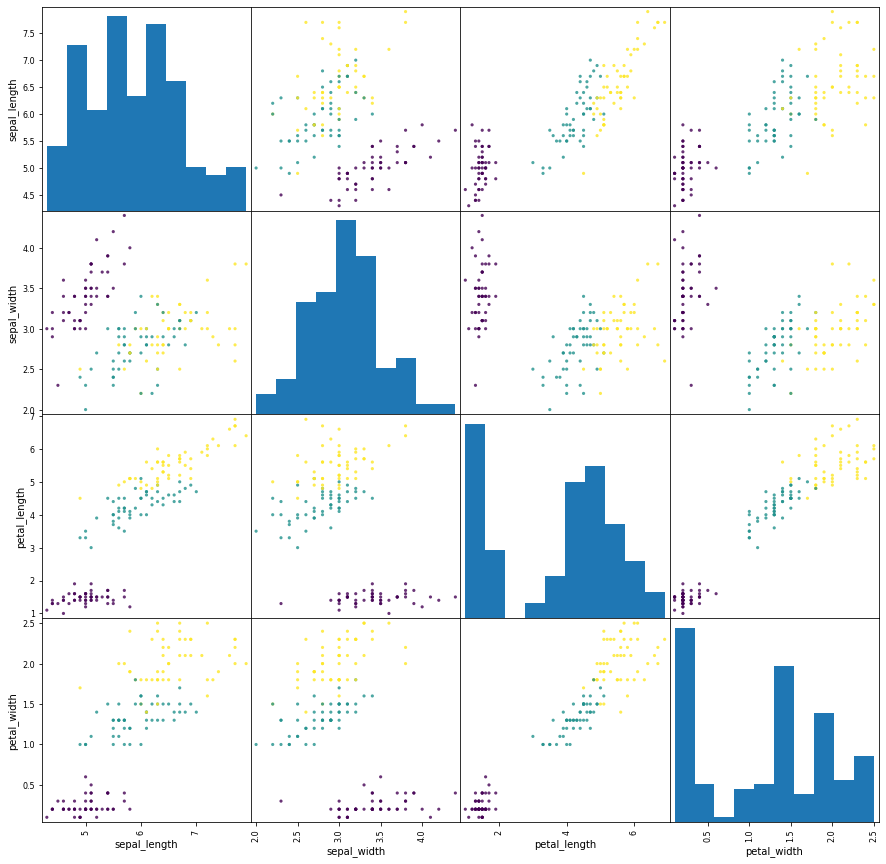

In [4]:
scatter_matrix(Data.iloc[:,:4],c=Data['species'],figsize=(15,15),marker='o', s=10,alpha=.8)
plt.show()

### Note:
Since this a small dataset Normalization is not applied but Incase you want to then the code is provided below:

```python
#Mean Normalizing the Data
def normalize(dataset):
    dataNorm=(dataset-dataset.mean())/(dataset.std())
    return dataNorm

#Normalizing except the species column
Data.iloc[:,:4] = normalize(Data.iloc[:,:4]) 

#Display the 1st five entries
Data.iloc[0:6,:]
```

In [5]:
#Splitting the Data into Validation and Training set

Data_Train = Data.values[:75,:]
Data_Validation = Data.values[75:,:]
m = Data.shape[0] #No of training sample ie 135
nInputNodes = Data.values.shape[1]-1 #No of features ie 4
nOutPutNodes = 3 #No of Output Nodes
print("No of Training Samples: ",m)
print("No of Input Node(Features): ",nInputNodes)
print("No of Output Node: ",nOutPutNodes)

No of Training Samples:  150
No of Input Node(Features):  4
No of Output Node:  3


## Model

In [6]:
class FF_Net:
    
    #parameters of the NeuralNetwork,self is the instance reference
    def __init__(self,inputNodes,hiddenNodes,outputNodes,learningRate):
        
        np.random.seed(200)
        self.nInputNodes = inputNodes
        self.nHiddenNodes = hiddenNodes
        self.nOutPutNodes = outputNodes
        self.lr = learningRate
        #Initializing the weights from Input to Hidden Layer
        #The Matrices are wih and who.
        self.Wih = np.random.normal(0.0,pow(nInputNodes,-0.5),(self.nHiddenNodes,self.nInputNodes)) #Weights between Input Layer and Hidden Layer
        self.Who = np.random.normal(0.0,pow(nInputNodes,-0.5),(self.nOutPutNodes,self.nHiddenNodes)) #Weights between Hidden Layer and Output Layer
        #Implimenting the Sigmoid Function
        self.activation_function=lambda x:scipy.special.expit(x)
        self.EHist = []
        self.Validation_Error = []
        pass
    
    def Train(self,Inputs,Targets):
        
        #calculate the summation of signals into hidden layer
        hidden_inputs = np.dot(self.Wih,Inputs)
        #calculaing the Hidden Output
        hidden_outputs = self.activation_function(hidden_inputs).reshape(self.nHiddenNodes,1)

        #calculate the summation of signals into output layer
        final_inputs = np.dot(self.Who, hidden_outputs)
        #calculaing the Final Output
        final_outputs = self.activation_function(final_inputs)

        # output layer error is the (target - actual)
        output_errors = Targets - final_outputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = np.dot(self.Who.T, output_errors)
    
        # update the weights for the links between the hidden and output layers
        self.Who += self.lr * np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))    
        # update the weights for the links between the input and hidden layers
        self.Wih += self.lr * np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(Inputs)) 
        
        return np.sum(np.square(output_errors))
    
    def Validation(self,Inputs,Targets):

        hidden_inputs = np.dot(self.Wih,Inputs)
        hidden_outputs = self.activation_function(hidden_inputs).reshape(self.nHiddenNodes,1)
        final_inputs = np.dot(self.Who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        output_errors = Targets - final_outputs
        hidden_errors = np.dot(self.Who.T, output_errors)
        
        return np.sum(np.square(output_errors))
    
    def run_Train(self,Data_Train, Data_Validation,epochs):
        for e in range(epochs):
            Error=0
            # go through all records in the training data set
            for record in Data_Train:
                targets = np.zeros(nOutPutNodes).reshape(3,1)
                targets[int(record[4])]=1
                Error += self.Train(record[0:4].reshape(4,1),targets)
            Error/=len(Data_Train)
            self.EHist.append(Error)
            VError=0
            for record in Data_Validation:
                targets = np.zeros(nOutPutNodes).reshape(3,1)
                targets[int(record[4])]=1
                VError += self.Validation(record[0:4].reshape(4,1),targets)
            VError/=len(Data_Validation)
            self.Validation_Error.append(VError)
            pass
        
    def Predict(self,inputs):

        hidden_inputs = np.dot(self.Wih,inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.Who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        return final_outputs 
       
        pass

## Function to plot our Model

In [7]:
def Plot(FF_Net):
    plt.figure(figsize=(7,7))
    plt.plot(FF_Net.EHist,label='Training Error')
    plt.plot(FF_Net.Validation_Error,label ='Validation error')
    plt.legend(loc='upper right')
    plt.title("Training Vs Validation Error [HiddenNodes={}]".format(FF_Net.nHiddenNodes))
    plt.xlabel("Number of Iterations")
    plt.ylabel("Error")
    plt.show()

## HyperParameter Tuning

Now we shall do a study based on Training Vs Validation error and see if our Model is **Overfitting.**<br>
Example of an **Overfitting** Model is give below:

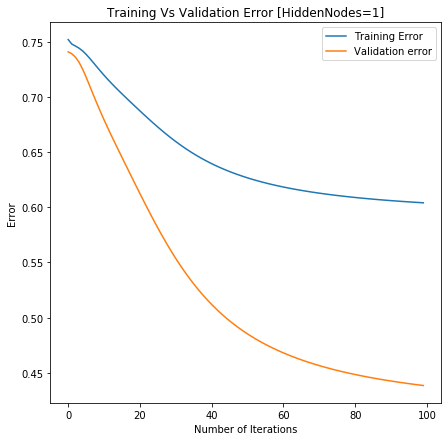

In [8]:
Model1 = FF_Net(nInputNodes,1,nOutPutNodes,0.03)
Model1.run_Train(Data_Train,Data_Validation,100)
Plot(Model1)

From the above example we can conclude that our Model is perfroming badly and it doesn't generalize well. So lets start tuning our Model.<br>
For this first we shall first figure out the no of **HiddenNodes** to be used and we shall keep the *Learning rate* as well as the *No of Iteration* as a constant 

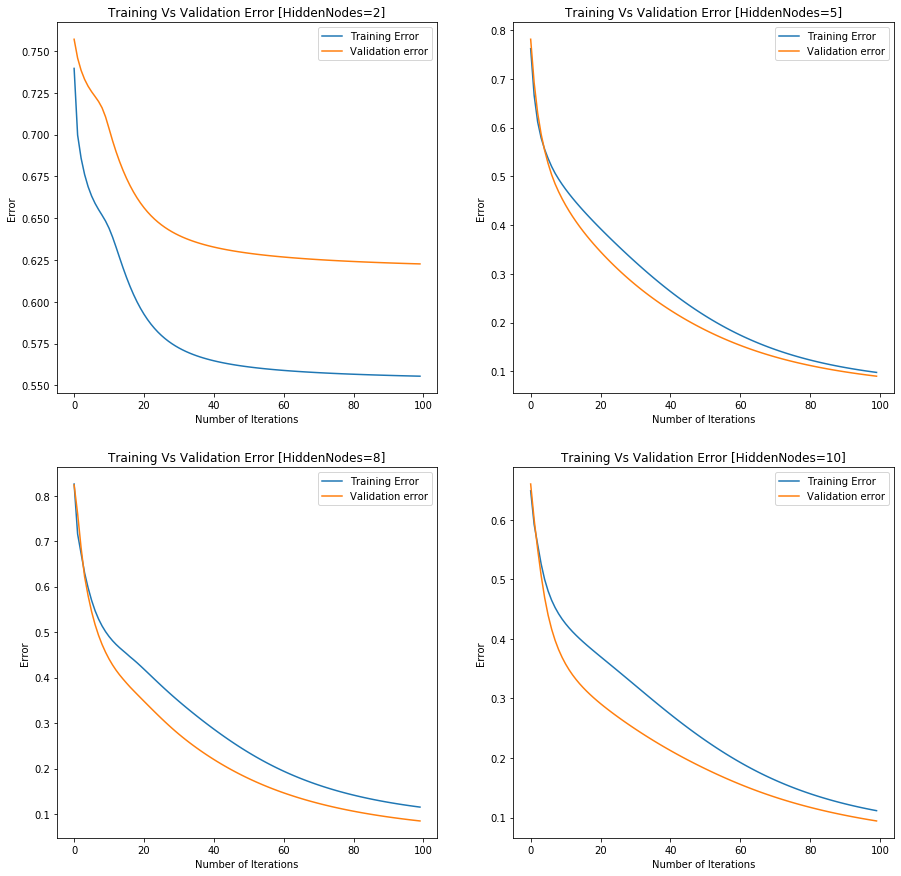

In [9]:
No_HNode = [2,5,8,10]
Models = []
for i in range(len(No_HNode)):
    Models.append(FF_Net(nInputNodes,No_HNode[i],nOutPutNodes,0.03))
    Models[i].run_Train(Data_Train,Data_Validation,100)
    
fig, ax = plt.subplots(2, 2,figsize=(15,15))
idx=0
for i in range(2):
    for j in range(2):
        ax[i,j].plot(Models[idx].EHist,label='Training Error')
        ax[i,j].plot(Models[idx].Validation_Error,label ='Validation error')
        ax[i,j].legend(loc='upper right')
        ax[i,j].set_title("Training Vs Validation Error [HiddenNodes={}]".format(Models[idx].nHiddenNodes))
        idx+=1
for i in ax.flat:
    i.set(xlabel='Number of Iterations', ylabel='Error')        

From the above plots we can conclude that **5** is the optimum no of *HiddenNodes*.<br>
Now based on this Model we shall find the *optimum Learning Rate*

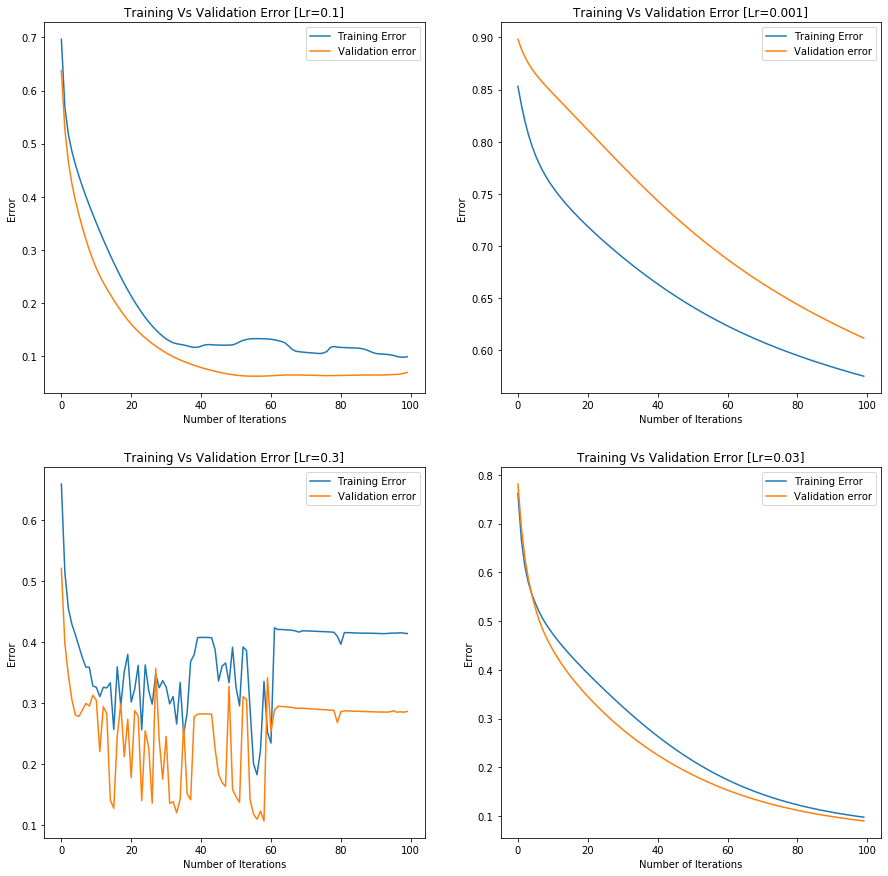

In [10]:
lr = [0.1,0.001,0.3,0.03]
ModelsLr = []
for i in range(len(lr)):
    ModelsLr.append(FF_Net(nInputNodes,5,nOutPutNodes,lr[i]))
    ModelsLr[i].run_Train(Data_Train,Data_Validation,100)

fig, ax = plt.subplots(2, 2,figsize=(15,15))
idx=0
for i in range(2):
    for j in range(2):
        ax[i,j].plot(ModelsLr[idx].EHist,label='Training Error')
        ax[i,j].plot(ModelsLr[idx].Validation_Error,label ='Validation error')
        ax[i,j].legend(loc='upper right')
        ax[i,j].set_title("Training Vs Validation Error [Lr={}]".format(ModelsLr[idx].lr))
        idx+=1
for i in ax.flat:
    i.set(xlabel='Number of Iterations', ylabel='Error')        

We can see from the above graphs that **0.001** seems to be a very good Learning Rate. Thus we have found our optim Model.

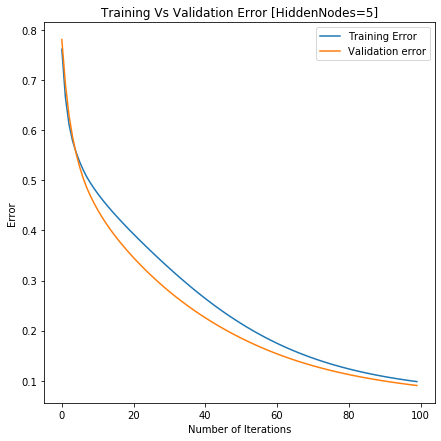

performance =  97.33333333333334 % Accurate


In [11]:
OptimModel = FF_Net(nInputNodes,5,nOutPutNodes,0.03)
OptimModel.run_Train(Data_Train,Data_Validation,100)
Plot(OptimModel)

scorecard = []
for record in Data.values:
    output = OptimModel.Predict(record[:4].reshape(4,1))
    if(int(record[4]) == np.argmax(output)):
        scorecard.append(1)
    else:
        scorecard.append(0)
        
scorecard_array = np.asarray(scorecard)
print ("performance = ", (scorecard_array.sum() / scorecard_array.size)*100,"% Accurate")              